# Human Responses

In [76]:
import pandas as pd
import numpy as np
import random

np.random.seed(0)
random.seed(0)

In [77]:
# We use 8 prompts, so both corpuses have the same number of prompts
n_prompts = 8
# We use a random n_samples_per_prompt samples for each prompt
n_samples_per_prompt = 100

## Reddit

In [78]:
pairs = []
for name in ["train", "test", "valid"]:
    with open("reddit/original_data/" + name + ".wp_source") as f_prompts:
        prompts = f_prompts.readlines()
    with open("reddit/original_data/" + name + ".wp_target") as f_responses:
        texts = f_responses.readlines()
    assert len(prompts) == len(texts)
    pairs.extend(list(zip(prompts, texts)))
df_reddit = pd.DataFrame(pairs, columns=["prompt", "text"])
df_reddit = df_reddit.drop_duplicates(subset=["text"])
df_reddit = df_reddit[~df_reddit["prompt"].str.contains("hitler", case=False)]
df_reddit = df_reddit[
    df_reddit["prompt"].isin(df_reddit["prompt"].value_counts().index[:n_prompts])
]
df_reddit["prompt_id"] = df_reddit["prompt"].astype("category").cat.codes

# Sample n_samples_per_prompt samples for each prompt
df_reddit = (
    df_reddit.groupby("prompt_id")
    .apply(lambda x: x.sample(n_samples_per_prompt), include_groups=False)
    .reset_index(drop=True)
)

# Break prompt into prompt and and prompt_tag
df_reddit["prompt_tag"] = (
    df_reddit["prompt"]
    .str.split(" \]", n=1)
    .str[0]
    .replace("\[", "", regex=True)
    .str.strip()
)
df_reddit["prompt"] = df_reddit["prompt"].str.split(" \]", n=1).str[1].str.strip()
df_reddit["prompt"] = "Prompt\n" + df_reddit["prompt"]
df_reddit = df_reddit.sort_values("prompt").reset_index(drop=True)
df_reddit["prompt_id"] = df_reddit["prompt"].astype("category").cat.codes

In [79]:
df_reddit_prompts = (
    df_reddit[["prompt_id", "prompt", "prompt_tag"]]
    .drop_duplicates()
    .sort_values("prompt_id")
    .reset_index(drop=True)
)


def modify_prompt(prompt):
    prompt = prompt.split("\n")[1]
    return "Write a response to the following creative writing prompt:\n" + prompt


df_reddit_prompts["prompt"] = df_reddit_prompts["prompt"].apply(modify_prompt)

df_reddit_prompts.to_csv("reddit/prompts.csv", index=False)

In [80]:
df_reddit = df_reddit[["prompt_id", "text"]]
df_reddit = df_reddit.sort_values("prompt_id").reset_index(drop=True)
df_reddit.to_csv("reddit/responses/human.csv", index=False)

```
WP: Writing Prompt
SP: Simple Prompt
EU: Established Universe
CW: Constrained Writing
TT: Theme Thursday
PM: Prompt Me
MP: Media Prompt
IP: Image Prompt
PI: Prompt Inspired
OT: Off Topic
* OT as an Advertisement!
RF: Reality Fiction
```

https://www.reddit.com/r/WritingPrompts/wiki/how_to_tag_prompts/

In [81]:
df_reddit_prompts

,prompt_id,prompt,prompt_tag
0,0,Write a response to the following creative wri...,WP
1,1,Write a response to the following creative wri...,WP
2,2,Write a response to the following creative wri...,WP
3,3,Write a response to the following creative wri...,WP
4,4,Write a response to the following creative wri...,CW
5,5,Write a response to the following creative wri...,WP
6,6,Write a response to the following creative wri...,WP
7,7,Write a response to the following creative wri...,WP


In [82]:
df_reddit

,prompt_id,text
0,0,Doh'tlec reviewed his message . It did n't nee...
1,0,We spoke to them in images . It was the only w...
2,0,`` The Savage within… '' those three words see...
3,0,It was a last resort . <newline> <newline> <ne...
4,0,You ’ ll give us your ships . We ’ ll win your...
...,...,...
795,7,In a sea of familiar faces just one pair of ey...
796,7,"Fair warning : This is a genuinely crap post ,..."
797,7,She was his first . And as far as he knew he w...
798,7,"`` Ugh , I 'm gon na be sick . I think-I think..."


In [83]:
print("Number of words in the responses:")
df_reddit["text"].apply(lambda x: len(x.split())).describe()

Number of words in the responses:


count     800.00000
mean      596.29875
std       492.29019
min       114.00000
25%       263.75000
50%       389.50000
75%       794.25000
max      2594.00000
Name: text, dtype: float64

## Hewlett

https://www.kaggle.com/competitions/asap-aes/code

In [84]:
import os

hewlett_prompts_dir = "hewlett/original_data/prompts"

prompts = []
for file in os.listdir(hewlett_prompts_dir):
    with open(hewlett_prompts_dir + "/" + file) as f:
        prompt = f.read()
    prompts.append((int(file.split(".")[0]) - 1, prompt))

df_hewlett_prompts = pd.DataFrame(prompts, columns=["prompt_id", "prompt"])
df_hewlett_prompts["prompt_tag"] = df_hewlett_prompts["prompt"].str.contains(
    "Source Essay"
)
df_hewlett_prompts["prompt_tag"] = df_hewlett_prompts["prompt_tag"].replace(
    {True: "source dependent responses", False: "persuasive / narrative / expository"}
)
df_hewlett_prompts = df_hewlett_prompts.sort_values("prompt_id").reset_index(drop=True)
df_hewlett_prompts.to_csv("hewlett/prompts.csv", index=False)

In [85]:
hewlett_dir = "hewlett/original_data"

filenames = [
    "training_set_rel3.tsv",
    "valid_set.tsv",
    "test_set.tsv",
]

dfs = []
for filename in filenames:
    df = pd.read_csv(f"{hewlett_dir}/{filename}", sep="\t", encoding="ISO-8859-1")
    df = df[["essay_set", "essay"]]
    df.rename(columns={"essay_set": "prompt_id", "essay": "text"}, inplace=True)
    df["prompt_id"] = df["prompt_id"].astype(int).apply(lambda x: x - 1)
    dfs.append(df)

# Don't need to remove the responses of any prompts because there are 8 distinct prompts in this dataset
df_hewlett = pd.concat(dfs, ignore_index=True)

df_hewlett = df_hewlett[df_hewlett["text"] != ""]
df_hewlett = df_hewlett.dropna()
df_hewlett = df_hewlett.drop_duplicates()

# Sample n_samples_per_prompt samples for each prompt
df_hewlett = (
    df_hewlett.groupby("prompt_id")
    .apply(lambda x: x.sample(n_samples_per_prompt), include_groups=False)
    .reset_index(level=0, drop=False)
    .reset_index(drop=True)
)
df_hewlett = df_hewlett[["prompt_id", "text"]]

df_hewlett.to_csv("hewlett/responses/human.csv", index=False)

In [86]:
df_hewlett_prompts

,prompt_id,prompt,prompt_tag
0,0,"Prompt\nMore and more people use computers, bu...",persuasive / narrative / expository
1,1,"Prompt\nCensorship in the Libraries\n""All of u...",persuasive / narrative / expository
2,2,Source Essay\nROUGH ROAD AHEAD: Do Not Exceed ...,source dependent responses
3,3,Source Essay\nWinter Hibiscus by Minfong Ho\nS...,source dependent responses
4,4,Source Essay\nNarciso Rodriguez\nfrom Home: Th...,source dependent responses
5,5,Source Essay\nThe Mooring Mast\nby Marcia Amid...,source dependent responses
6,6,Prompt\nWrite about patience. Being patient me...,persuasive / narrative / expository
7,7,Prompt\nWe all understand the benefits of laug...,persuasive / narrative / expository


In [87]:
df_hewlett

,prompt_id,text
0,0,"Well, in my opinion I feel that computers have..."
1,0,"Dear, Local Newspaper @CAPS1 here to inform yo..."
2,0,The effects computers have on people vary from...
3,0,"Dear @CAPS1, I agreed with the people that fee..."
4,0,"Dear newspaper, Some people say that computers..."
...,...,...
795,7,"In the story i am going to tell you, it invol..."
796,7,I met my best friend @PERSON2 when we were in...
797,7,Laughter is a common occurrence in my home. @...
798,7,Having laughter in your life is a big part in...


# LLM response generation

## Aggregate generation

In [14]:
from tqdm import tqdm
import pandas as pd


def generate_responses(dataset_name, generate, model_name, temp=None):
    output_filename = (
        f"{dataset_name}_responses/{model_name}.csv"
        if temp == None
        else f"{dataset_name}_responses/{model_name}_{temp}.csv"
    )
    if os.path.exists(output_filename):
        print(f"{output_filename} already exists")
        return

    prompts_df = pd.read_csv(f"{dataset_name}_prompts.csv")
    prompt_ids = []
    responses = []

    progress_bar = tqdm(total=len(prompts_df) * n_samples_per_prompt)

    for prompt, prompt_id in zip(prompts_df["prompt"], prompts_df["prompt_id"]):
        for _ in range(n_samples_per_prompt):
            prompt_ids.append(prompt_id)
            if temp is not None:
                responses.append(generate(model_name, prompt, temp))
            else:
                responses.append(generate(model_name, prompt))
            progress_bar.update(1)

    progress_bar.close()

    df = pd.DataFrame({"prompt_id": prompt_ids, "text": responses})
    df.to_csv(output_filename, index=False)

## Gemini (1.0 and 1.5)

In [15]:
GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

In [16]:
import time
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold


with open("API_KEY_GOOGLE.txt", "r") as f:
    API_KEY_GOOGLE = f.read()

genai.configure(api_key=API_KEY_GOOGLE)


def generate_gemini(model_name, prompt):
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    }

    model = genai.GenerativeModel(
        f"models/{model_name}", safety_settings=safety_settings
    )

    while True:
        start = time.time()
        response = model.generate_content(prompt)
        # Gemini sometimes returns an empty response due to "SAFETY", so try again
        if not response.parts:
            print(response.candidates)
            continue
        # Gemini has a rate limit of 15 requests per minute for 1.0 and 2 requests per minute for 1.5
        wait_time = 30 if "1.5" in model_name else 4
        time.sleep(max(0, wait_time + 1 - (time.time() - start)))
        return " ".join([part.text for part in response.parts])

/home2/hstropkay/llm-style/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
generate_responses("reddit", generate_gemini, GEMINI_10)
generate_responses("reddit", generate_gemini, GEMINI_15)

generate_responses("hewlett", generate_gemini, GEMINI_10)
generate_responses("hewlett", generate_gemini, GEMINI_15)

reddit_responses/gemini-1.0-pro.csv already exists
reddit_responses/gemini-1.5-pro-latest.csv already exists
hewlett_responses/gemini-1.0-pro.csv already exists
hewlett_responses/gemini-1.5-pro-latest.csv already exists


## GPT (3.5, 4.0, and 3.5 with temp = [0.0, 0.1,...,1.5])

In [18]:
GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"

In [19]:
from openai import OpenAI

with open("API_KEY_OPENAI.txt", "r") as f:
    API_KEY_OPENAI = f.read()


def generate_gpt(model_name, prompt, temp=None):
    client = OpenAI(api_key=API_KEY_OPENAI)

    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ]
    response = None
    if temp != None:
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
            temperature=temp,
        )
    else:
        response = client.chat.completions.create(
            model=model_name,
            messages=messages,
        )
    return response.choices[0].message.content

In [20]:
generate_responses("reddit", generate_gpt, GPT_35)
generate_responses("reddit", generate_gpt, GPT_40)
for temp in [i / 10 for i in range(14)]:
    generate_responses("reddit", generate_gpt, GPT_35, temp)

generate_responses("hewlett", generate_gpt, GPT_35)
generate_responses("hewlett", generate_gpt, GPT_40)
for temp in [i / 10 for i in range(14)]:
    generate_responses("hewlett", generate_gpt, GPT_35, temp)

reddit_responses/gpt-3.5-turbo-0125.csv already exists
reddit_responses/gpt-4-turbo-2024-04-09.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.0.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.1.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.2.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.3.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.4.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.5.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.6.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.7.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.8.csv already exists
reddit_responses/gpt-3.5-turbo-0125_0.9.csv already exists
reddit_responses/gpt-3.5-turbo-0125_1.0.csv already exists
reddit_responses/gpt-3.5-turbo-0125_1.1.csv already exists
reddit_responses/gpt-3.5-turbo-0125_1.2.csv already exists
reddit_responses/gpt-3.5-turbo-0125_1.3.csv already exists
hewlett_responses/gpt-3.5-turbo-0125.csv already exists
hewl

## TODO: temp > 1.3

```
openai.InternalServerError: Error code: 500 - {'error': {'message': 'Failed to create completion as the model generated invalid Unicode output. Unfortunately, this can happen in rare situations. Consider reviewing your prompt or reducing the temperature of your request. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID req_58f0042493a451bb309b48e5330706ea in your message.)', 'type': 'server_error', 'param': None, 'code': 'invalid_model_output'}}
```

## Claude (Sonnet and Opus)

In [21]:
CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

In [22]:
import anthropic

with open("API_KEY_ANTHROPIC.txt", "r") as f:
    API_KEY_ANTHROPIC = f.read()


def generate_claude(model_name, prompt):
    client = anthropic.Anthropic(api_key=API_KEY_ANTHROPIC)

    message = client.messages.create(
        model=model_name,
        max_tokens=4096,
        messages=[{"role": "user", "content": prompt}],
    )

    return message.content[0].text

In [23]:
generate_responses("reddit", generate_claude, CLAUDE_SONNET)
generate_responses("reddit", generate_claude, CLAUDE_OPUS)

generate_responses("hewlett", generate_claude, CLAUDE_SONNET)
generate_responses("hewlett", generate_claude, CLAUDE_OPUS)

reddit_responses/claude-3-sonnet-20240229.csv already exists
reddit_responses/claude-3-opus-20240229.csv already exists
hewlett_responses/claude-3-sonnet-20240229.csv already exists
hewlett_responses/claude-3-opus-20240229.csv already exists


## Response lengths

[]

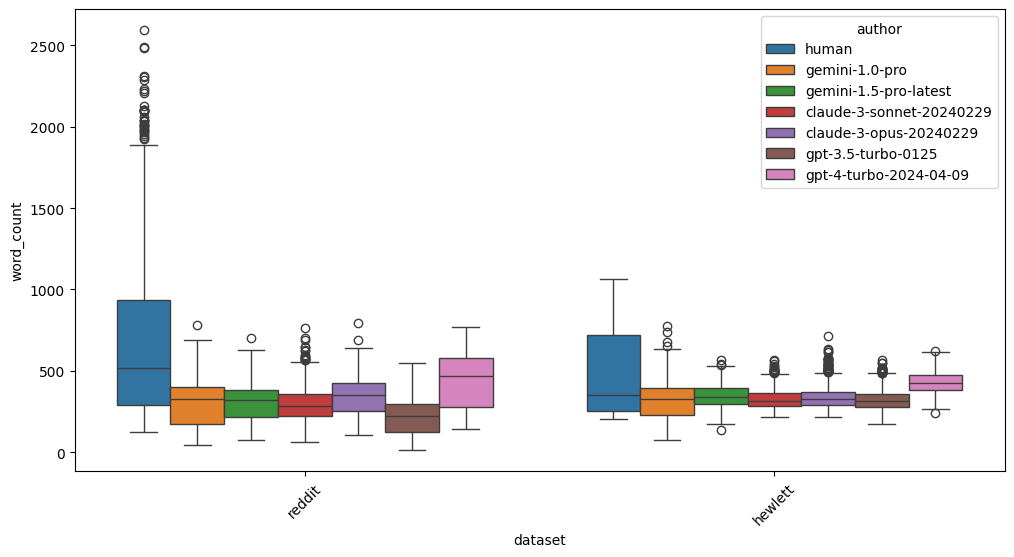

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


HUMAN = "human"

GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"


authors = [HUMAN, GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]

df_word_counts = []
for dataset in ["reddit", "hewlett"]:
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["word_count"] = df["text"].apply(lambda x: len(x.split()))
        df["dataset"] = dataset
        df["author"] = author
        df_word_counts.append(df)

df_word_counts = pd.concat(df_word_counts, ignore_index=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x="dataset", y="word_count", hue="author", data=df_word_counts)
plt.xticks(rotation=45)
plt.plot()